Laboratorio 4 - Modelo de Regresión Logística Polinomial

By Cristian Laynez - 201281

El objetivo de este laboratorio es crear un modelo de regresión logística polinomial que prediga fielmente si un paciente sufrirá de un paro cardíaco.


Información Extra: 
para la data set proveida donde se muestran las condiciones físicas y contextuales para más de 4000 pacientes de enfermedades cardíacas. El dataset relaciona a cada paciente con una etiqueta (1 = tuvo un paro cardíaco, 0 = no tuvo paro cardíaco)

Task 1.1 - Leer archivo proporcionado y almacenarlo en un np.array

In [73]:
# Importar todas las librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import csv
from numpy.linalg import inv

In [74]:
# --> Leer la data proporcionada
f = open('framingham.csv', 'r')
reader = csv.reader(f)
header = next(reader, None)

# Se guardara la data en un diccionario
data = {}
for h in header:
    data[h] = []

# Se guardaran todos los valores
for row in reader:
    for h, v in zip(header, row):      
        d = 0.0 if v == "NA" else float(v)
        data[h].append(d)
        # temp = [d]
        # data[h].append(temp)

In [75]:
# Imprimir todos los headers que se encontraron
print(header)

['sex', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']


In [76]:
# Modelos con solo 1's y 0's
print(data['sex']) # hombre (1) o mujer (0)
print(data['currentSmoker']) # Si es fumador o no
print(data['BPMeds']) # Si el paciente esta tomando medicamentos para la presión alta
print(data['prevalentStroke']) # Si el paciente a tenido un derrame cerebral
print(data['prevalentHyp']) # Si el paciente era hipertenso
print(data['diabetes']) # Si el paciente tiene diabetes
print(data['TenYearCHD'])

[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,

Task 1.2 - Ajustar modelo logístico polinomial (Tomando en cuenta la variable dependiente de salida [sufre o no subre un paro cardíaco])

In [77]:
# --> TODO: Funciones que nos ayudaran a ajustar el modelo logistico polinomial

# Signo sigmoid
sigmoid = lambda z : 1 / (1 + np.exp(-z))

# Predecir probabilidades
predict_prob = lambda X, theta : sigmoid(np.dot(X, theta))

# Predecir las etiquetas impuestas
predict_labels = lambda X, theta, threshold=0.5 : (predict_prob(X, theta) >= threshold).astype(int)

# Costo y gradiente
def cost_and_grad_function(X, y, theta, lambda_reg):
    m = X.shape[0]
    h = sigmoid(np.dot(X, theta))
    cost = -1/m * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) + lambda_reg/(2*m) * np.sum(np.square(theta[1:]))
    gradient = 1/m * np.dot(X.T, (h - y)) + lambda_reg/m * np.vstack(([[0]], theta[1:]))
    return cost, gradient

# Obtener descenso de gradiente
def gradient_descent(X, y, theta, alpha, num_iters, lambda_reg):
    decline_res = []
    for i in range(num_iters):
        cost, gradient = cost_and_grad_function(X, y, theta, lambda_reg)
        decline_res.append(cost)
        theta -= alpha * gradient
    return theta, decline_res

In [78]:
# ----> Definiendo modelo de regresion logistica polinomal
def create_polinomial_3(X, degree):
    n = X.shape[0]
    m = int((degree + 1) * (degree + 2) / 2)
    x_pol = np.zeros((n, m))
    x_pol[:, 0] = 1
    count = 1
    for i in range(1, degree + 1):
        for j in range(i + 1):
            x_pol[:, count] = X[:, 0]**(i - j) * X[:, 1]**j
            count += 1
    return x_pol

def logistic_polinomial_model(degree, lambda_region, X, y):
    X_poly = create_polinomial_3(X, degree)
    X_poly = np.insert(X_poly, 0, 1, axis=1)    
    m, n = X_poly.shape
    theta = np.zeros((n, 1))    
    theta, _ = gradient_descent(X_poly, y, theta, alpha=0.1, num_iters=1000, lambda_reg=lambda_region)
    X_poly = create_polinomial_3(X, degree)
    X_poly = np.insert(X_poly, 0, 1, axis=1)
    h = sigmoid(X_poly @ theta)
    y_pred = (h >= 0.5).astype(int)
    return y_pred

In [79]:
DATASET_SET_SIZE = len(data['sex'])
DEGREE = 3
LAMBDA_REGION = 0.1
ALPHA = 0.001
ITERATIONS_COUNT = 1000

In [80]:
# ---> Preparacion de datoss
# Para X: age, sysBP, cigsPerDay, glucose, prevalentStroke (Ya que son los datos más influyentes para que ocurra un paro cardiaco)
x = np.array([data['age'], data['sysBP'], data['cigsPerDay'], data['glucose'], data['prevalentStroke']]).T

# Para Y : TenYearCHD
y = np.array(data['TenYearCHD'])

In [81]:
# ---> Vamos a dividir los datos en conjuntos de train and test
m = x.shape[0]
m_train = int(m * 0.7)
m_test = m - m_train
X_train = x[:m_train, :]
X_test = x[m_train:, :]
y_train = y[:m_train]
y_test = y[m_train:]

# ----> Se normalizaran los datos para un mejor manejo de datos
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

Task 1.3 - Utilizar implementación vectorial del algoritmo de regresioń logística polinomial

In [82]:
# ---> Obtener conjuntos de train and test por medio del modelo de regresion logistica polinomial
Xm_train = create_polinomial_3(X_train_norm, DEGREE)
Xm_test = create_polinomial_3(X_test_norm, DEGREE)

theta = np.zeros((Xm_train.shape[1], 1)) # Definir theta

# ---> Obtener modelo por medio de los datos de entrenamieto
theta, dimensions = gradient_descent(Xm_train, y_train.reshape(-1, 1), theta, ALPHA, ITERATIONS_COUNT, LAMBDA_REGION)

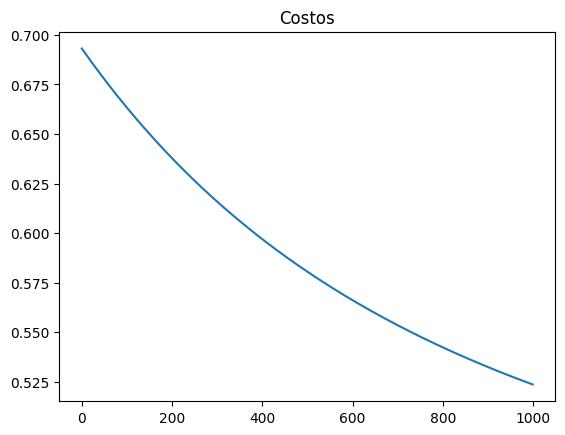

In [83]:
# ! Graficar costos
plt.plot(np.squeeze(dimensions))
plt.title("Costos")
plt.show()

In [84]:
# Obtener predicciones en el conjunto de entrenamiento y prueba
y_train_pred = predict_labels(Xm_train, theta)
y_test_pred = predict_labels(Xm_test, theta)

# Obtener la precisión del modelo en el conjunto de entrenamiento y prueba
presision_train = np.mean(y_train == y_train_pred.reshape(-1))
presision_test = np.mean(y_test == y_test_pred.reshape(-1))
print(f'Precisión con el conjunto de entrenamiento: {presision_train:.2f}')
print(f'Precisión con el conjunto de pruebas: {presision_test:.2f}')

Precisión con el conjunto de entrenamiento: 0.85
Precisión con el conjunto de pruebas: 0.85


Task 1.4 - Determinar el grado del polinomio que mejor describe la nube de puntos (cross-validation)

Task 1.5 - Análisis sobre sus hallazgos

El modelo implementado ha sido procesador de una manera exitosa y efectiva. Se puede apreciar que los factores edad, presion en la sangre, cigarros por dia, glucosa y si el paciente a sufrido de un ataque son más propensos a sufrir un paro cardiaco. 